<a href="https://colab.research.google.com/github/georgezefko/Twitter-Sentiment-Analysis/blob/main/Exploratory_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import seaborn as sns
from collections import Counter
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger') 
from nltk import sent_tokenize
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings 
warnings.filterwarnings('ignore')
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [3]:
train_data = '/content/drive/MyDrive/disaster_tweet/'
train = pd.read_csv(train_data+'train.csv')
test = pd.read_csv(train_data+'test.csv')

In [4]:
train.head() #print the top five rows

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [6]:
train.info() # look at some basic info on each column keyword and location have numerous missin values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


### Preliminary analysis




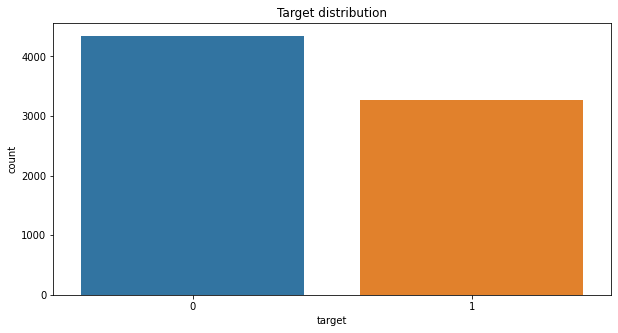

In [7]:
plt.figure(figsize=(10,5))
sns.countplot(x=train.target)
plt.title('Target distribution')
plt.show()

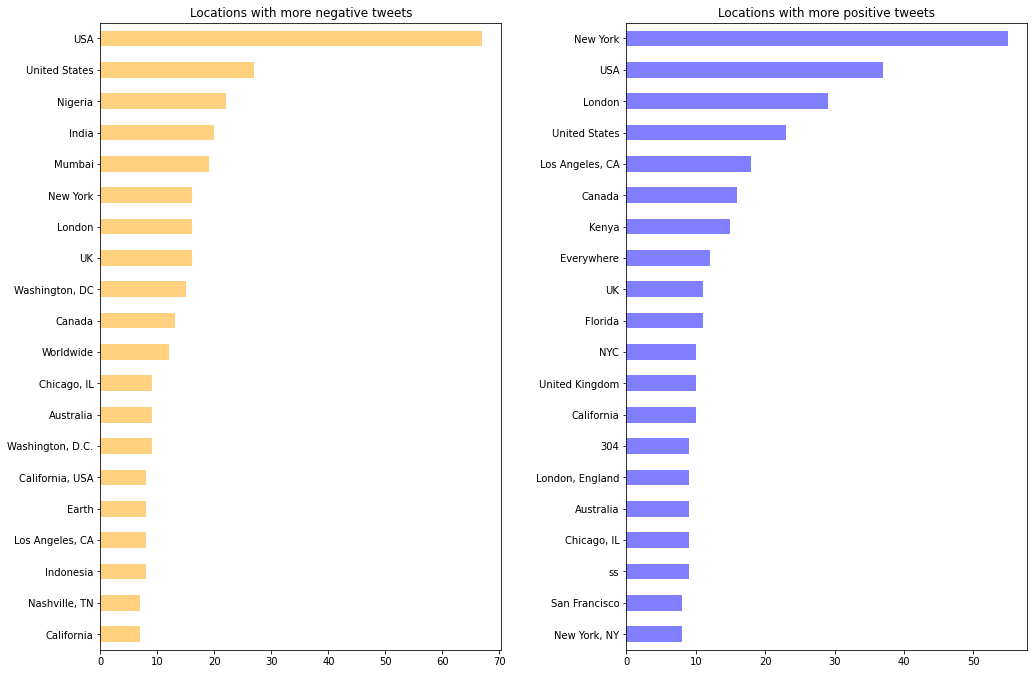

In [11]:

fig, axes = plt.subplots(ncols = 2 , sharey=False,figsize=(15,10))
train[train['target']==1]['location'].value_counts().iloc[:20].sort_values(ascending=True).plot(kind='barh',
                                                                                                alpha=0.5,
                                                                                                facecolor='orange', 
                                                                                                title='Locations with more negative tweets',ax = axes[0])

train[train['target']==0]['location'].value_counts().iloc[:20].sort_values(ascending=True).plot(kind='barh',
                                                                                                alpha=0.5,
                                                                                                facecolor='blue', 
                                                                                                title='Locations with more positive tweets',ax = axes[1])
fig.tight_layout(pad=3)
plt.show()

In location level we can see that further cleaning is needed since the same names are repeated throughout the data. 

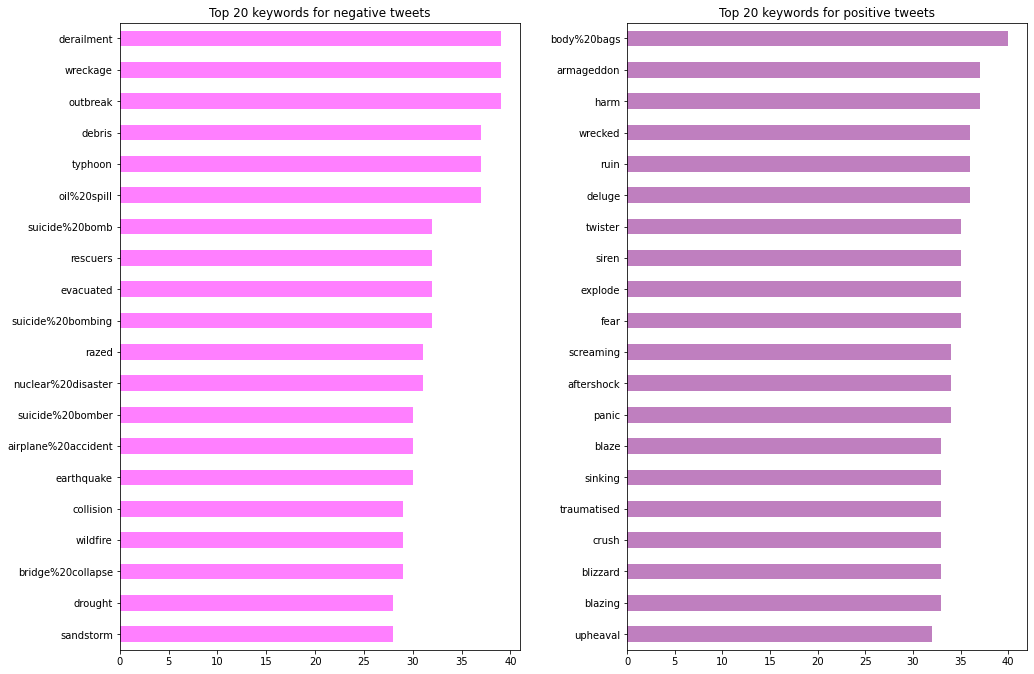

In [12]:
fig, axes = plt.subplots(ncols = 2 , sharey=False,figsize=(15,10))
train[train['target']==1]['keyword'].value_counts().iloc[:20].sort_values(ascending=True).plot(kind='barh',alpha=0.5,
                                                                                               facecolor='magenta',
                                                                                               title='Top 20 keywords for negative tweets',ax = axes[0])

train[train['target']==0]['keyword'].value_counts().iloc[:20].sort_values(ascending=True).plot(kind='barh',alpha=0.5,
                                                                                               facecolor='purple',
                                                                                               title='Top 20 keywords for positive tweets', ax = axes[1])
fig.tight_layout(pad=3)
plt.show()


From the above graphs we can see that the keywords between negative and positive tweets cannot be distingusihed. For example the positive tweets have words that could easily reflect on a negative tweet. Thus, it seems that they can't be used to help us with the analysis

#Text EDA

In the first step we saw that there are no null values in text. However, we need to test whether there are any duplicates in the data.

In [13]:
#check for duplicates
pd.concat(g for _, g in train.groupby("text") if len(g) > 1)

,id,keyword,location,text,target
4290,6094,hellfire,"Jubail IC, Saudi Arabia.",#Allah describes piling up #wealth thinking it...,0
4299,6105,hellfire,?????? ??? ?????? ????????,#Allah describes piling up #wealth thinking it...,0
4312,6123,hellfire,?????? ???? ??????,#Allah describes piling up #wealth thinking it...,1
6363,9095,suicide%20bomb,Nigeria,#Bestnaijamade: 16yr old PKK suicide bomber wh...,1
6366,9098,suicide%20bomb,Nigeria,#Bestnaijamade: 16yr old PKK suicide bomber wh...,1
...,...,...,...,...,...
6094,8702,sinking,NaN,that horrible sinking feeling when youÛªve be...,0
6103,8714,sinking,NaN,that horrible sinking feeling when youÛªve be...,0
6123,8739,sinking,MA,that horrible sinking feeling when youÛªve be...,1
5620,8018,refugees,NaN,wowo--=== 12000 Nigerian refugees repatriated ...,1


In [14]:
# dropping ALL duplicte values
train.drop_duplicates(subset ="text",
                     keep = False, inplace = True)

In [15]:
train.info() # we can see that the number of entries reduced from 7613 to 7434

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7434 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7434 non-null   int64 
 1   keyword   7378 non-null   object
 2   location  4982 non-null   object
 3   text      7434 non-null   object
 4   target    7434 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 348.5+ KB


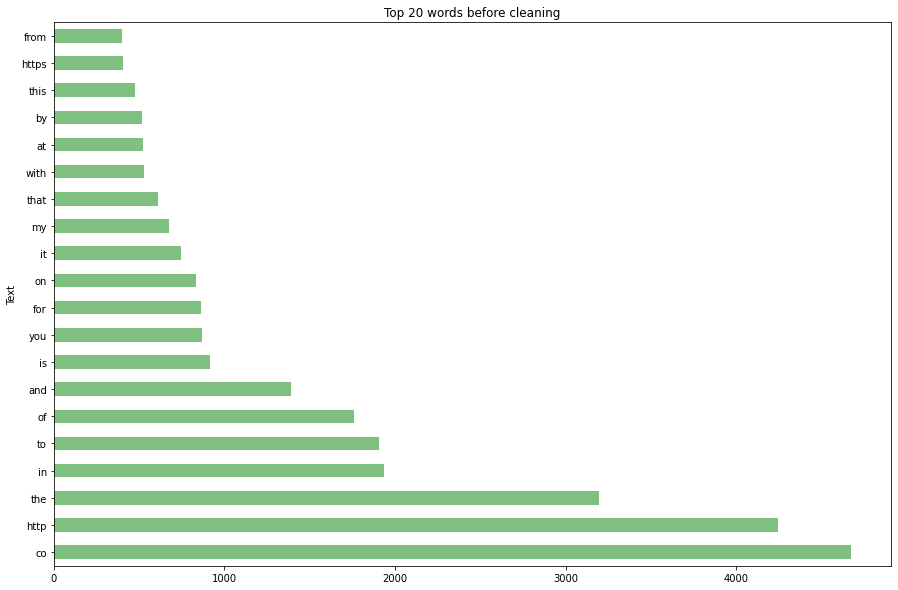

In [16]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(train['text'], 20)
df1 = pd.DataFrame(common_words, columns = ['Text' , 'count'])

plt.figure(figsize=(15,10))
df1.groupby('Text').sum()['count'].sort_values(ascending=False).plot(kind='barh', 
                                                                     title= 'Top 20 words before cleaning',
                                                                     alpha=0.5,
                                                                     facecolor='Green')
plt.show()

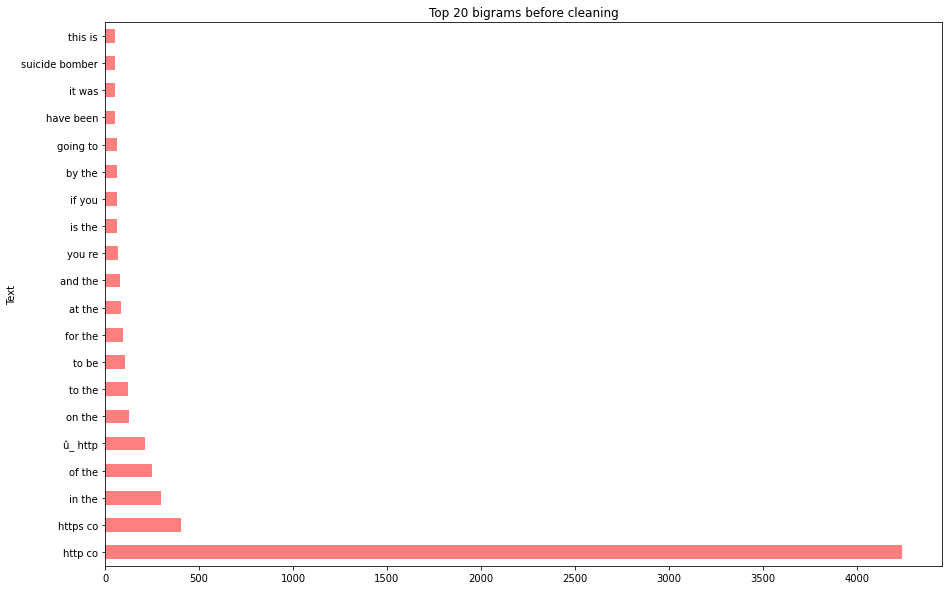

In [17]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]


common_words = get_top_n_bigram(train['text'], 20)

df2 = pd.DataFrame(common_words, columns = ['Text' , 'count'])

plt.figure(figsize=(15,10))
df2.groupby('Text').sum()['count'].sort_values(ascending=False).plot(
    kind='barh', alpha=0.5,facecolor='red',title='Top 20 bigrams before cleaning')
plt.show()

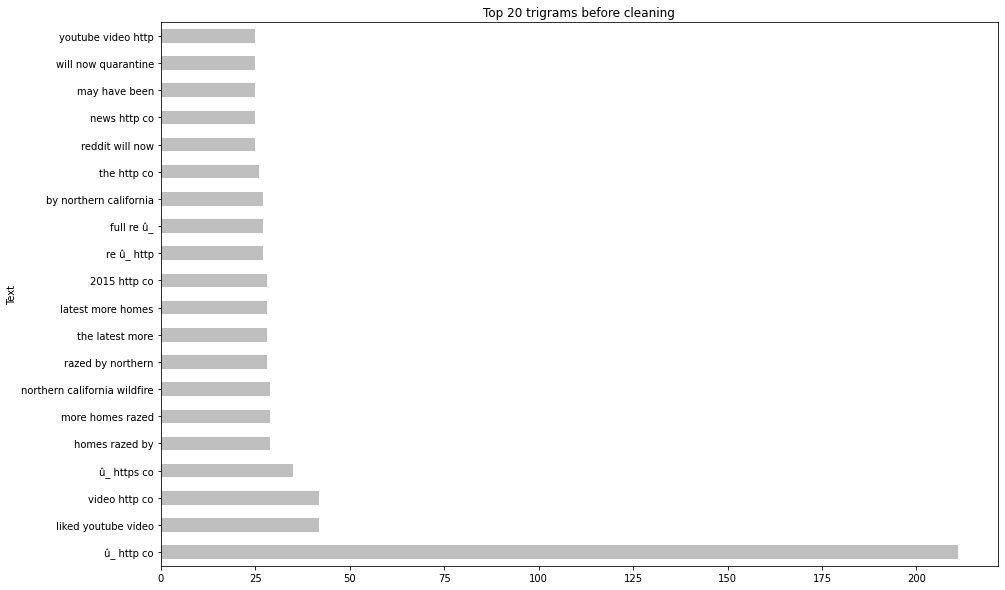

In [18]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]


common_words = get_top_n_trigram(train['text'], 20)

df3 = pd.DataFrame(common_words, columns = ['Text' , 'count'])

plt.figure(figsize=(15,10))
df3.groupby('Text').sum()['count'].sort_values(ascending=False).plot(
    kind='barh', alpha=0.5,facecolor='grey', title='Top 20 trigrams before cleaning')


### Text Cleaning

In [21]:
STOPWORDS = nltk.corpus.stopwords.words('english')

def clean_text(text):
    """
    Applies some pre-processing on the given text.

    Steps :
    - Removing HTML tags
    - Removing punctuation
    - Lowering text
    """
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    
    # remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # remove the characters [\], ['] and ["]
    text = re.sub(r"\\", "", text)    
    text = re.sub(r"\'", "", text)    
    text = re.sub(r"\"", "", text)
    text = re.sub(r"http\S+", "", text)
    text = re.sub('[0-9]+', '', text)
    text = re.sub(r'\b\w\b', ' ', text)
    text = re.sub('@[^\s]+','',text)
    text = emoji_pattern.sub(r'', text)

    # Special characters
    text = re.sub(r"\x89Û_", "", text)
    text = re.sub(r"\x89ÛÒ", "", text)
    text = re.sub(r"\x89ÛÓ", "", text)
    text = re.sub(r"\x89ÛÏWhen", "When", text)
    text = re.sub(r"\x89ÛÏ", "", text)
    text = re.sub(r"China\x89Ûªs", "China's", text)
    text = re.sub(r"let\x89Ûªs", "let's", text)
    text = re.sub(r"\x89Û÷", "", text)
    text = re.sub(r"\x89Ûª", "", text)
    text = re.sub(r"\x89Û\x9d", "", text)
    text = re.sub(r"å_", "", text)
    text = re.sub(r"\x89Û¢", "", text)
    text = re.sub(r"\x89Û¢åÊ", "", text)
    text = re.sub(r"fromåÊwounds", "from wounds", text)
    text = re.sub(r"åÊ", "", text)
    text = re.sub(r"åÈ", "", text)
    text = re.sub(r"JapÌ_n", "Japan", text)    
    text = re.sub(r"Ì©", "e", text)
    text = re.sub(r"å¨", "", text)
    text = re.sub(r"SuruÌ¤", "Suruc", text)
    text = re.sub(r"åÇ", "", text)
    text = re.sub(r"å£3million", "3 million", text)
    text = re.sub(r"åÀ", "", text)       
    
    # convert text to lowercase
    text = text.strip().lower()
    
    # replace punctuation characters with spaces
    filters='!"\'#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
    translate_dict = dict((c, " ") for c in filters)
    translate_map = str.maketrans(translate_dict)
    text = text.translate(translate_map)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS if len(word)>=3) # remove stopwords from text

    return text


def tokenize(text):
  tokens = nltk.word_tokenize(text)
  return tokens

lemmatizer = WordNetLemmatizer()
def lemmatize(text):
  lem_list = [lemmatizer.lemmatize(word) for word in text]
  return lem_list

def rejoin_words(text):
  joined_words = (" ".join(text))
  return joined_words

In [22]:
train['text']=train['text'].apply(clean_text)
train['text']=train['text'].apply(tokenize)
train['text']=train['text'].apply(lemmatize)
train['text']=train['text'].apply(rejoin_words)

In [23]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,deed reason earthquake may allah forgive,1
1,4,NaN,NaN,forest fire near ronge sask canada,1
2,5,NaN,NaN,resident asked shelter place notified officer ...,1
3,6,NaN,NaN,people receive wildfire evacuation order calif...,1
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfire pour...,1


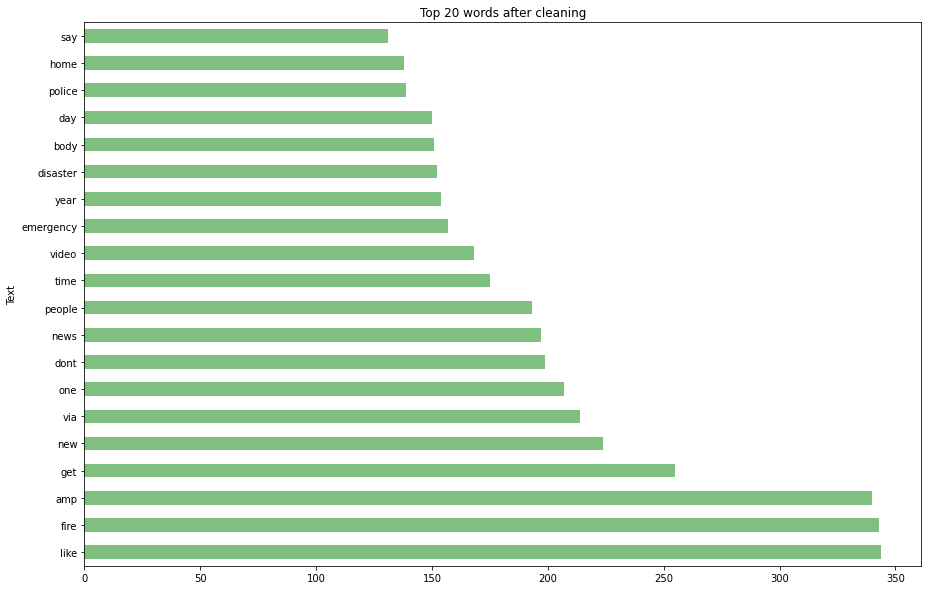

In [24]:
common_words = get_top_n_words(train['text'], 20)
df1_b = pd.DataFrame(common_words, columns = ['Text' , 'count'])

plt.figure(figsize=(15,10))
df1_b.groupby('Text').sum()['count'].sort_values(ascending=False).plot(kind='barh', 
                                                                     title= 'Top 20 words after cleaning',
                                                                     alpha=0.5,
                                                                     facecolor='Green')
plt.show()

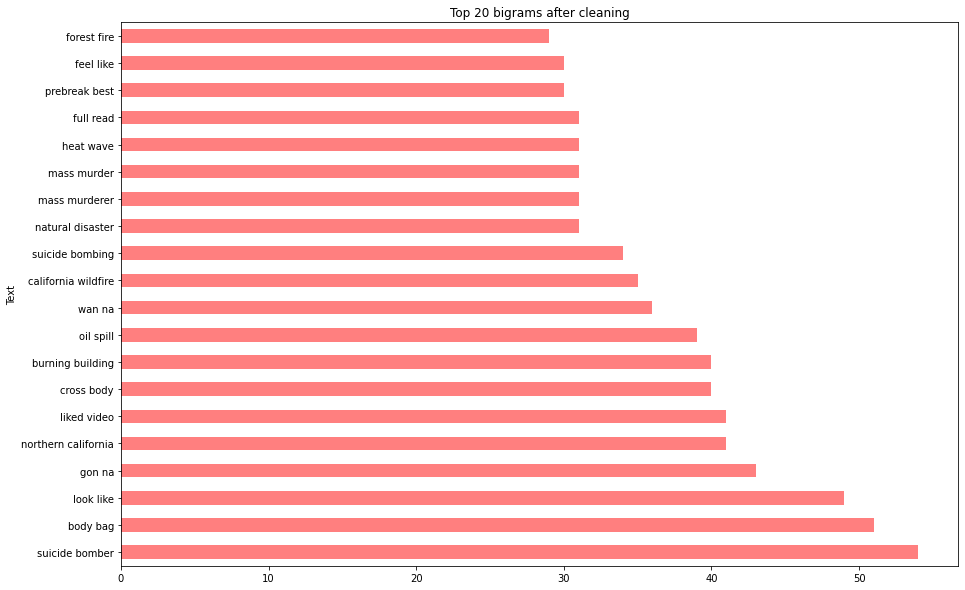

In [25]:
common_words = get_top_n_bigram(train['text'], 20)

df2_b = pd.DataFrame(common_words, columns = ['Text' , 'count'])

plt.figure(figsize=(15,10))
df2_b.groupby('Text').sum()['count'].sort_values(ascending=False).plot(
    kind='barh', alpha=0.5,facecolor='red',title='Top 20 bigrams after cleaning')
plt.show()

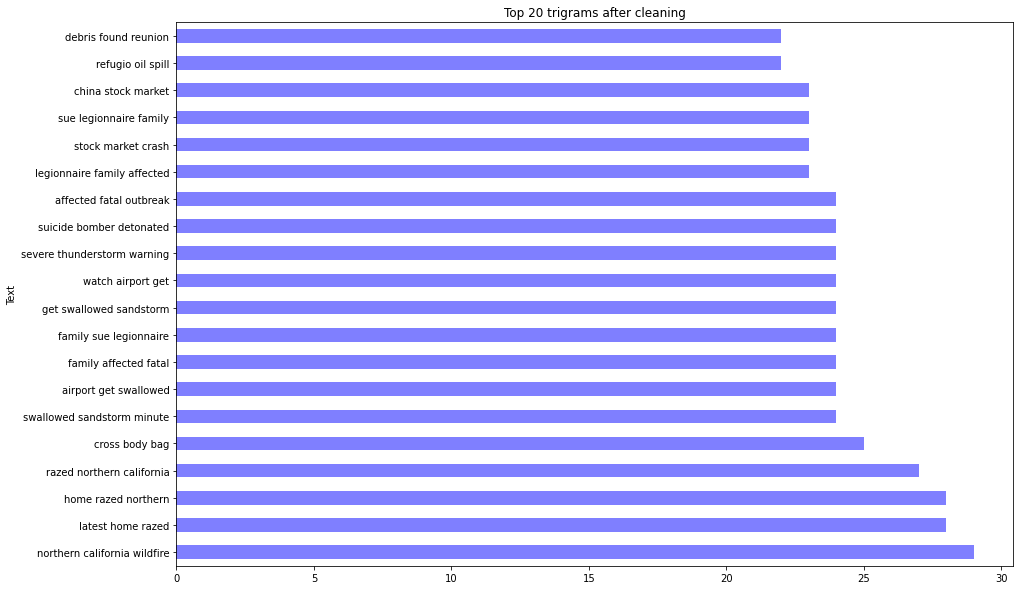

In [26]:
common_words = get_top_n_trigram(train['text'], 20)

df3_b = pd.DataFrame(common_words, columns = ['Text' , 'count'])

plt.figure(figsize=(15,10))
df3_b.groupby('Text').sum()['count'].sort_values(ascending=False).plot(
    kind='barh', alpha=0.5,facecolor='blue', title='Top 20 trigrams after cleaning')

### Polarity exploration

In [27]:
train['polarity'] = train['text'].map(lambda text: TextBlob(text).sentiment.polarity)
train['word_count'] = train['text'].apply(lambda x: len(str(x).split()))

In [28]:
print('5 random reviews with the highest positive sentiment polarity: \n')
cl = train.loc[train.polarity >0, ['text']].sample(5).values
for c in cl:
    print(c[0])

5 random reviews with the highest positive sentiment polarity: 

keep drown insult feel devote pride ten fold action reprocussions set birth retroactive
meat loving feminist world riot grill arrived oliviamiles
latest home razed northern california wildfire latest wildfire burning california
completely understand woke like minute ago burning
thats beyond adorable hope wont wrecked noticed


In [29]:
print('5 random reviews with the most negative sentiment polarity: \n')
cl = train.loc[train.polarity < 0, ['text']].sample(5).values
for c in cl:
    print(c[0])

5 random reviews with the most negative sentiment polarity: 

hollywood movie trapped miner released chile hollywood movie trapped miner starring
news update enugu government demolish illegal structure international conference centre via daily post
white twister black shift knob thread size
politics democracy hatred hate dawabsha threaten erode israeli democracy homegrown terrorism
rockyfire update california hwy closed direction due lake county fire cafire wildfire


In [30]:
print('5 random reviews with neutral sentiment polarity: \n')
cl = train.loc[train.polarity == 0, ['text']].sample(5).values
for c in cl:
    print(c[0])

5 random reviews with neutral sentiment polarity: 

one talking risk suicide bomber hiding amongst migrant stowing aboard eurotunnel train
radioactive box quarantined israel ashdod port evacuated emergency team discovered radiation emittin
court back session testimony continues med examiner discussing gunshot wound kerricktrial
feel attacked
render assistance gain proxy hostage fortune ssu


In [31]:
train.polarity.min()

-1.0

In [32]:

train.loc[train.polarity == -1.0]


,id,keyword,location,text,target,polarity,word_count
143,205,airplane%20accident,Hyderabad Telangana INDIA,horrible accident man died wing airplane,1,-1.0,6
145,209,airplane%20accident,bangalore,horrible accident man died wing airplane watch...,1,-1.0,7
152,218,airplane%20accident,NaN,unbelievably insane man airport airplane aircr...,1,-1.0,10
153,219,airplane%20accident,Mumbai india,horrible accident man died wing airplane,1,-1.0,6
154,220,airplane%20accident,sri lanka,horrible accident man died wing airplane,1,-1.0,6
162,235,airplane%20accident,India,omg horrible accident man died wing airplane,1,-1.0,7
166,241,airplane%20accident,Fashion Heaven. IG: TMId_,phone look like car ship airplane accident ter...,0,-1.0,8
426,617,arsonist,ss,trick think nasty thing,0,-1.0,4
454,657,attack,Freeport IL. USA,horrific attack wife muslim italy liveleak news,1,-1.0,7
501,726,attacked,"Los Angeles, CA",worst person questioning julie attacked guy em...,0,-1.0,7


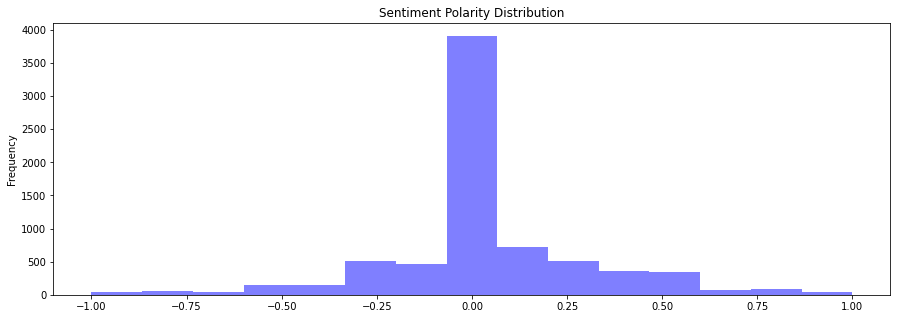

In [33]:
plt.figure(figsize=(15,5))
train['polarity'].plot(
    kind='hist',
    bins=15,
    alpha=0.5,
    facecolor='blue',
    title='Sentiment Polarity Distribution')

plt.show()

In [ ]:
#analyze the wrong polarities

In [34]:
cor_neg_pol = 0
mis_neg_pol= 0
cor_pos_pol = 0
mis_pos_pol = 0
for i,j in enumerate(train['polarity']):
  if j < 0:
    if train['target'].iloc[i]==1:
      cor_neg_pol +=1
    else:
      mis_neg_pol+=1
  if j > 0:
    if train['target'].iloc[i]==1:
      cor_pos_pol +=1
    else:
      mis_pos_pol+=1

print('The correct negative classified according to polarity are:',cor_neg_pol)
print('The wrongly negative classified according to polarity are:',mis_neg_pol)
print(80*'-')
print('The correct positive classified according to polarity are:',cor_pos_pol)
print('The wrongly positive classified according to polarity are:',mis_pos_pol)

The correct negative classified according to polarity are: 748
The wrongly negative classified according to polarity are: 829
--------------------------------------------------------------------------------
The correct positive classified according to polarity are: 798
The wrongly positive classified according to polarity are: 1514


Based on polarity we can see that the majority of words classified as neutral. The more we investigate into it we can see that that there are wrong classied tweets for both categories. Thus polarity doesn't contitute a correct approach to predict disastrous tweets.

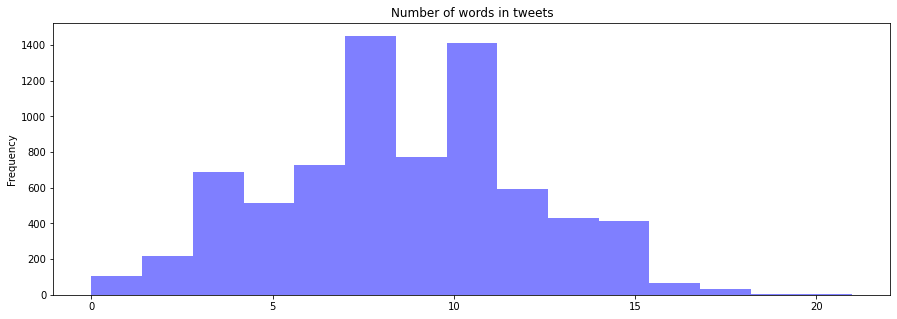

In [35]:
plt.figure(figsize=(15,5))
train['word_count'].plot(
    kind='hist',
    bins=15,
    alpha=0.5,
    facecolor='blue',
    title='Number of words in tweets')

plt.show()


Maybe there is a pattern that more negative tweets are generated with fewer words since people would be in some sort of a hurry when face an uncomfortable situation

In [36]:
neg_bel_10 = 0 #negative below 10 words
pos_bel_10= 0 #positive below 10 words
neg_abo_10 = 0 #negative above 10 words
pos_abo_10 = 0 #positive above 10 words
for i,j in enumerate(train['word_count']):
  if j < 10:
    if train['target'].iloc[i]==1:
      neg_bel_10 +=1
    else:
      pos_bel_10+=1
  if j > 10:
    if train['target'].iloc[i]==1:
      neg_abo_10 +=1
    else:
      pos_abo_10+=1

In [ ]:
print('Negative tweets below 10 words:',neg_bel_10)
print('Positive tweets below 10 words:',pos_bel_10)
print(80*'-')
print('Negative tweets above 10 words:',neg_abo_10)
print('Positive tweets below 10 words:',pos_abo_10)

Negative tweets below 10 words: 1763
Positive tweets below 10 words: 2698
--------------------------------------------------------------------------------
Negative tweets above 10 words: 1064
Positive tweets below 10 words: 1238


From the above results it seems that no pattern links the length of tweets with their category

From the analysis above we can conclude that keyword, country and id are not useful for detecting the tweet positivity thus, we will exclude them in order to proceed further

exporting to csv for later use in pytorch

In [37]:
#prepare csv files for train and validation iterators
train.to_csv('/content/drive/MyDrive/disaster_tweet/dataset_train.csv', index=False)

